# FIGRL in Python (train and inductive) test full network timeframe 4

In [1]:
# FI-GRL (Python)
import networkx as nx
import numpy as np
from scipy.sparse import csr
import networkx as nx
import scipy
from components.GraphConstruction import GraphConstruction
import pandas as pd 

timeframe specifes which timeframe is selected. The undersampling_rate defines the graph-level undersampling rate defined as the desired ratio of fraudulent transactions over legitimate ones. add_additional_datais a boolean indicating whether or not we would like to add the original transaction features to the transaction node embeddings before training and evaluating our downstream classification model.

For FI-GRL specifically there are two global parameters the intermediate_dim and final_dimension. the final_dimension indicates the embedding size of the created figrl embeddings. 

In [2]:
# Global parameters:
timeframe = 4
undersampling_rate = None
add_additional_data = True
intermediate_dim = 100
final_dimension = 10

### 1. Loading the Credit Card Transaction Data

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import numpy as np
import time

df = pd.read_csv("D:\\Users\\r0630151\\Downloads\\PIPELINE\\Preprocessing\\preprocessed_ccf.csv", index_col = "Unnamed: 0")

#### 1.1. Selecting a Timeframe

In [4]:
from components.Timeframes import Timeframes
from datetime import datetime, timedelta

tf = Timeframes(df['TX_DATETIME'],step_size=5, window_size=17)
timeframe_indices = tf.get_timeframe_indices(timeframe)

print('number of days in dataset: ',tf.get_number_of_days())
print('number of timeframes derived from window and step size: ',tf.get_number_of_timeframes())

number of days in dataset:  36
number of timeframes derived from window and step size:  5


In [5]:
hold_out = 5
train_data, inductive_data = tf.train_inductive_split(df.loc[timeframe_indices],hold_out)

In [6]:
print('The distribution of fraud for the train data is:\n', train_data['TX_FRAUD'].value_counts())
print('The distribution of fraud for the inductive data is:\n', inductive_data['TX_FRAUD'].value_counts())

The distribution of fraud for the train data is:
 0    1204079
1       7273
Name: TX_FRAUD, dtype: int64
The distribution of fraud for the inductive data is:
 0    500000
1      5898
Name: TX_FRAUD, dtype: int64


#### 1.2. Selecting an Undersampling Rate

In [7]:
from imblearn.under_sampling import RandomUnderSampler

if not undersampling_rate is None:
    print("An undersampling rate of ", undersampling_rate, "is applied.")
    train_data['index'] = train_data.index
    undersample = RandomUnderSampler(sampling_strategy=(undersampling_rate))
    X, y = undersample.fit_resample(train_data, train_data['TX_FRAUD'])
    train_data = X.set_index(X['index']).drop('index',axis=1)
    print('The new distribution for the train set is:\n', train_data["TX_FRAUD"].value_counts())

In [8]:
from components.GraphConstruction import GraphConstruction

nodes = {"transaction":train_data.index, "client":train_data.CARD_PAN_ID, "merchant":train_data.TERM_MIDUID}
edges = [zip(train_data.CARD_PAN_ID, train_data.index),zip(train_data.TERM_MIDUID, train_data.index)]

graph = GraphConstruction(nodes, edges)
figrl_graph = graph.get_edgelist()


### Training

In [9]:
import time
t0 = time.time()
A = nx.adjacency_matrix(graph.g_nx)
#FIGRL hyperparameter (intermediate_dim)
dim = intermediate_dim

In [10]:
n,m = A.shape
diags = A.sum(axis=1).flatten()

with scipy.errstate(divide='ignore'):
   diags_sqrt = 1.0/np.lib.scimath.sqrt(diags)
diags_sqrt[np.isinf(diags_sqrt)] = 0
DH = scipy.sparse.spdiags(diags_sqrt, [0], n, n, format='csr')

Normalized_random_walk = (DH.dot(A)).dot(DH)

#S = np.random.randn(n, dim) / np.sqrt(dim)
S = np.array(pd.read_csv('S_train_matrix.csv', header=None))
#np.savetxt("S_train_matrix.csv", S, delimiter=",")

C = Normalized_random_walk.dot(S)

from scipy import sparse
sC = sparse.csr_matrix(C)

U, sigma, V = scipy.sparse.linalg.svds(sC, k=final_dimension, tol=0,which='LM')

t1 = time.time()
print(t1-t0)

V = V.transpose()


169.82421588897705


In [11]:
sigma = np.diag(sigma)

In [12]:
figrl_train_emb = pd.DataFrame(U)
figrl_train_emb = figrl_train_emb.set_index(figrl_train_emb.index+1)
#figrl_train_emb = figrl_train_emb.loc[train_data.index]
figrl_train_emb = figrl_train_emb.iloc[:len(train_data.index),:]

### 2.2.2. Inductive Step FI-GRL 

In [13]:
import numpy as np
sigma = np.array(sigma)
V = np.array(V)
S = np.array(S)

In [14]:
train_data['index'] = train_data.index
inductive_data['index'] = inductive_data.index
inductive_graph_data = pd.concat((train_data,inductive_data))
inductive_graph_data = inductive_graph_data.set_index(inductive_graph_data['index']).drop("index",axis = 1)

nodes = {"transaction": inductive_graph_data.index, "client":inductive_graph_data.CARD_PAN_ID.unique(), "merchant": inductive_graph_data.TERM_MIDUID.unique()}
edges = [zip(inductive_graph_data.CARD_PAN_ID, inductive_graph_data.index),zip(inductive_graph_data.TERM_MIDUID, inductive_graph_data.index)]

graph = GraphConstruction(nodes, edges)

In [15]:
import collections

inductive_dict = {}
for node in inductive_data.index:
    client = inductive_data.loc[node].CARD_PAN_ID
    merchant = inductive_data.loc[node].TERM_MIDUID
    inductive_dict[node] = [client,merchant]
inductive_dict = collections.OrderedDict(sorted(inductive_dict.items()))


In [16]:
import networkx as nx
degrees = nx.degree(graph.g_nx)
degrees = dict(degrees)
degrees = collections.OrderedDict(sorted(degrees.items()))


The 'get_vector' function is our implementation of the normalized random walk vector used in the paper of Jiang et al. This calculates this vector in a compressed way, reserving space and saving time.

In [17]:
from scipy.sparse import coo_matrix

def get_vector(inductive_dict, max_id):
    print("creating sparse vector matrix")
    row  = []
    col  = []
    data = []
    location_finder = {}
    i = 0
    k = 0
    for node, v in inductive_dict.items():
        for n in v:
            if n is not None:
                row.append(i)
                if n in location_finder.keys():
                    x = location_finder.get(n)
                    col.append(x)
                    inductive_degree = len([x for x in v if x != None])
                    value = 1/np.sqrt(inductive_degree)
                    value = value * (1/np.sqrt(degrees[n]))
                    data.append(value)
                else:
                    col.append(k)
                    location_finder[n] = k
                    #calculate value
                    inductive_degree = len([x for x in v if x != None])
                    value = 1/np.sqrt(inductive_degree)
                    value = value * (1/np.sqrt(degrees[n]))
                    data.append(value)
                    k+=1
                
        i+=1        
    row = np.array(row)
    col = np.array(col)
    data = np.array(data)
    return coo_matrix((data, (row, col)), shape=(len(inductive_dict), k))


In [18]:
import time
t0 = time.time()
v = get_vector(inductive_dict, max(inductive_graph_data.TERM_MIDUID))
t1 = time.time()
print(t1-t0)

creating sparse vector matrix
6.4949047565460205


In [19]:
x,y = v.shape
S = S[:y,:]

In [20]:
import scipy as sp
import scipy.sparse

t0 = time.time()
inductive_degrees = []
for l in inductive_dict.values():
    x = 0
    for i in l:
        if i is not None:
            x+=1                     
    inductive_degrees.append(x)
    
def sqrt_d_inv(inductive_degrees):
        sqrt_d_inv = np.array([1/np.sqrt(degree)  if degree > 0 else 0 for degree in inductive_degrees])
        return sp.sparse.spdiags(sqrt_d_inv,0, sqrt_d_inv.size, sqrt_d_inv.size)
sqrt_d_inv = sqrt_d_inv(inductive_degrees)
t1 = time.time()
print(t1-t0)

1.2484948635101318


In [21]:
t0 = time.time()
p = v.dot(S)
U =(p.dot(V)).dot(np.linalg.inv(sigma))
U = sqrt_d_inv.dot(U)
t1 = time.time()

print(t1-t0)


0.754296064376831


The vector v is now of a compressed length instead of the length of the maxid. This creates the opportunity and the need to reduce the size of S

In [22]:
figrl_inductive_emb = pd.DataFrame(U, index=inductive_data.index)

### 4. Classification: predictions based on inductive embeddings

In [23]:
from xgboost import XGBClassifier
classifier = XGBClassifier(n_estimators=100)

In [24]:
figrl_train_emb.index= range(train_data.first_valid_index(),train_data.first_valid_index()+figrl_train_emb.last_valid_index())

In [25]:
train_labels = train_data['TX_FRAUD']

if add_additional_data is True:
    figrl_train_emb_wf = pd.merge(figrl_train_emb, train_data.drop('TX_FRAUD', axis=1).drop('TX_DATETIME', axis=1), left_index=True, right_index=True)
    figrl_inductive_emb_wf = pd.merge(figrl_inductive_emb, inductive_data.loc[figrl_inductive_emb.index].drop('TX_FRAUD', axis=1).drop('TX_DATETIME', axis=1), left_index=True, right_index=True)
    
    baseline_train = train_data.drop('TX_FRAUD', axis=1).drop('TX_DATETIME', axis=1)
    baseline_inductive = inductive_data.drop('TX_FRAUD', axis=1).drop('TX_DATETIME', axis=1).loc[figrl_inductive_emb.index]
    
    classifier.fit(baseline_train, train_labels)
    baseline_predictions = classifier.predict_proba(baseline_inductive)

    classifier.fit(figrl_train_emb_wf, train_labels)
    figrl_predictions = classifier.predict_proba(figrl_inductive_emb_wf)

### 5. Evaluation

Average precision-recall score for  FIGRL+features  configuration XGBoost: 0.4933890881
Average precision-recall score for  Baseline  configuration XGBoost: 0.2807964937
FI-GRL: 
The  1.0 % Lift is equal to:  44.896397618310786
Baseline: 
The  1.0 % Lift is equal to:  31.027344275494237


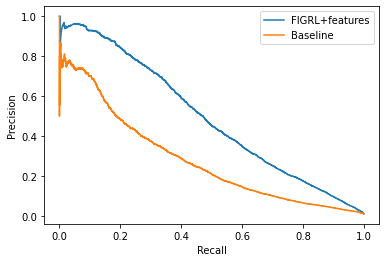

In [26]:
from components.Evaluation import Evaluation
import warnings
warnings.filterwarnings("ignore")

inductive_labels = df.loc[figrl_inductive_emb.index]['TX_FRAUD']

figrl_evaluation = Evaluation(figrl_predictions, inductive_labels, "FIGRL+features") 

figrl_evaluation.pr_curve()

if add_additional_data is True:
    baseline_evaluation = Evaluation(baseline_predictions, inductive_labels, "Baseline")
    baseline_evaluation.pr_curve()

print("FI-GRL: ")
lift_score = figrl_evaluation.lift_score(0.01)

if add_additional_data is True:
    print("Baseline: ")
    lift_score = baseline_evaluation.lift_score(0.01)
